In [1]:
import os

os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"
)

import pyspark
from pyspark.sql import SparkSession
from App.utils import *
from graphframes import *

hdfs_host = "hdfs://localhost:9000"
hdfs_root_path = "/SafeEntry_Analytics/"

conf = pyspark.SparkConf().setAppName("Explore Entry Record").setMaster("local[*]")
sc = pyspark.SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)

resident_file_dest = "resident.parquet"
place_file_dest = "place.parquet"
safe_entry_file_dest = "entry_record.parquet"
contact_graph_edge_file_dest = "contact_graph_edge.parquet"
contact_graph_vertex_file_dest = "contact_graph_vertex.parquet"

communities_file_dest = "communities.parquet"

#### Step 1: Retrieve Graph Data

In [2]:
e = read_parquet_file(spark, hdfs_host + hdfs_root_path + contact_graph_edge_file_dest)
v = read_parquet_file(spark, hdfs_host + hdfs_root_path + contact_graph_vertex_file_dest)
g = GraphFrame(v, e)

g.edges.show()
g.vertices.show()


+--------+--------+
|     src|     dst|
+--------+--------+
|rid_1140|rid_1576|
|rid_1576|rid_1140|
|rid_1140|rid_1596|
|rid_1596|rid_1140|
|rid_1642|rid_1386|
|rid_1386|rid_1642|
| rid_575|rid_1245|
|rid_1245| rid_575|
| rid_913|rid_1151|
|rid_1151| rid_913|
|rid_1705| rid_759|
| rid_759|rid_1705|
|rid_1885|rid_1754|
|rid_1754|rid_1885|
|rid_1885| rid_566|
| rid_566|rid_1885|
| rid_766|rid_1216|
|rid_1216| rid_766|
|rid_1754| rid_566|
| rid_566|rid_1754|
+--------+--------+
only showing top 20 rows

+------+----------------+--------+------------+--------------------+
|    id|   resident_name|    nric|phone_number|      last_update_dt|
+------+----------------+--------+------------+--------------------+
| rid_1| resident_name_1|S000001U|    80000001|2021-04-13 23:22:...|
| rid_2| resident_name_2|S000002J|    80000002|2021-04-13 23:22:...|
| rid_3| resident_name_3|F000003Q|    80000003|2021-04-13 23:22:...|
| rid_4| resident_name_4|F000004E|    80000004|2021-04-13 23:22:...|
| rid_5| re

#### Step 2: visualize in NetworkX

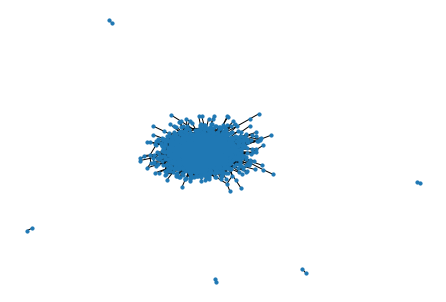

In [3]:
g_pdf = g.edges.select("*").toPandas()

import networkx as nx
import matplotlib.pyplot as plt
g_nx = nx.from_pandas_edgelist(g_pdf, source='src', target='dst')
nx.draw(g_nx,node_size = 10)
plt.show()

#### Step 3.1: Find Close Node

In [4]:
from pyspark.sql.functions import explode

confirmed_cases = ['rid_949']

shortest_path_df = g.shortestPaths(landmarks=confirmed_cases)
shortest_path_df.select("id", "distances").orderBy('id').show(20,False)

shortest_path_df=shortest_path_df.select("id", explode("distances"))

print(f"============close contact as below============")
shortest_path_df.filter(shortest_path_df.value == 1).show()

+--------+--------------+
|id      |distances     |
+--------+--------------+
|rid_1   |[rid_949 -> 5]|
|rid_10  |[rid_949 -> 6]|
|rid_100 |[rid_949 -> 7]|
|rid_1000|[rid_949 -> 2]|
|rid_1001|[rid_949 -> 6]|
|rid_1002|[rid_949 -> 4]|
|rid_1003|[rid_949 -> 6]|
|rid_1004|[rid_949 -> 6]|
|rid_1005|[rid_949 -> 5]|
|rid_1006|[rid_949 -> 5]|
|rid_1007|[rid_949 -> 7]|
|rid_1008|[rid_949 -> 5]|
|rid_1009|[rid_949 -> 6]|
|rid_101 |[rid_949 -> 6]|
|rid_1010|[rid_949 -> 2]|
|rid_1011|[rid_949 -> 5]|
|rid_1012|[rid_949 -> 3]|
|rid_1013|[rid_949 -> 5]|
|rid_1014|[rid_949 -> 8]|
|rid_1015|[]            |
+--------+--------------+
only showing top 20 rows

============close contact as below============
+--------+-------+-----+
|      id|    key|value|
+--------+-------+-----+
| rid_896|rid_949|    1|
| rid_649|rid_949|    1|
|rid_1805|rid_949|    1|
|rid_1294|rid_949|    1|
|rid_1087|rid_949|    1|
+--------+-------+-----+



#### Step 3.2: Community Detection
##### Build model, can not use SCC and CC

In [5]:
communities_df = g.labelPropagation(maxIter=10)

from pyspark.sql import functions as func
communities_df.sort("label").groupby("label").agg(func.collect_list("id")).show()

communities_df.orderBy("label").show()

communities_hdfs_path = hdfs_host + hdfs_root_path + communities_file_dest
communities_df.write.mode("Overwrite").parquet(communities_hdfs_path)

+------------+--------------------+
|       label|    collect_list(id)|
+------------+--------------------+
| 94489280520|           [rid_619]|
|103079215105|          [rid_1330]|
|128849018883|[rid_1119, rid_86...|
|137438953473|          [rid_1307]|
|171798691843|           [rid_292]|
|206158430214| [rid_789, rid_1505]|
|214748364802|          [rid_1242]|
|214748364809|[rid_1400, rid_87...|
|223338299396|          [rid_1691]|
|223338299398|[rid_1765, rid_1853]|
|231928233994|           [rid_668]|
|249108103171|          [rid_1543]|
|249108103172| [rid_432, rid_1627]|
|266287972353|          [rid_1387]|
|292057776137|          [rid_1357]|
|300647710721|          [rid_1531]|
|300647710724|           [rid_249]|
|309237645317|[rid_1473, rid_16...|
|317827579916|           [rid_452]|
|317827579918|             [rid_5]|
+------------+--------------------+
only showing top 20 rows

+--------+------------------+--------+------------+--------------------+------------+
|      id|     resident_

##### Find Cluster for resident

In [6]:
resident_id = 'rid_1152'
label = communities_df.filter("id = '" + resident_id + "'" ).collect()[0]['label']

print('============Resident in the same cluster============')
communities_df.filter("label = '"+ str(label) +"'").show()

============Resident in the same cluster============
+--------+------------------+--------+------------+--------------------+------------+
|      id|     resident_name|    nric|phone_number|      last_update_dt|       label|
+--------+------------------+--------+------------+--------------------+------------+
|rid_1066|resident_name_1066|S001066Q|    80001066|2021-04-13 23:22:...|481036337159|
|rid_1475|resident_name_1475|F001475U|    80001475|2021-04-13 23:22:...|481036337159|
|rid_1899|resident_name_1899|F001899S|    80001899|2021-04-13 23:22:...|481036337159|
| rid_367| resident_name_367|F000367J|    80000367|2021-04-13 23:22:...|481036337159|
| rid_970| resident_name_970|S000970Y|    90000970|2021-04-13 23:22:...|481036337159|
|  rid_90|  resident_name_90|F000090S|    80000090|2021-04-13 23:22:...|481036337159|
| rid_591| resident_name_591|S000591K|    90000591|2021-04-13 23:22:...|481036337159|
| rid_714| resident_name_714|S000714E|    90000714|2021-04-13 23:22:...|481036337159|
|